In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import gymnasium as gym
from gymnasium import spaces

In [2]:
# Rewards
RUN_OUT_GASOLINE = -10
WHEAT_HARVESTED = 0
EMPTY_CELL = -1
OBSTACLE_ENCOUNTERED = -100
GASOLINE_SPENT = -1

In [3]:
class FarmEnv(gym.Env):
    def __init__(self, grid_size, obstacles, combine):
        super(FarmEnv, self).__init__()
        self.grid_size = grid_size
        self.action_space = spaces.Discrete(5)  # Actions: up, down, left, right, harvest
        self.observation_space = spaces.Box(low=0, high=1, shape=(grid_size[0], grid_size[1], 3), dtype=np.float32)
        self.combine = combine  # Include combine in the environment
        self.obstacles = obstacles
        self.harvester_path = []
        self.reset()

    def reset(self):
        self.grid = np.full(self.grid_size, 1)  # Initialize entire grid with wheat
        self.position_harvester = [0, 0]  # Example initial position
        for pos in self.obstacles:
            self.grid[pos[0], pos[1]] = -1  # Place obstacles
        self.harvester_path = [list(self.position_harvester)]
        return self._get_observation(), self._get_reward(), self._check_done(), {}
        
    def step(self, action):
        # Handle out of gasoline scenario
        if self.combine.gasoline <= 0:
            return self._get_observation(), RUN_OUT_GASOLINE, True, {}  # Use constant for penalty
                                                
        # Update the position of the harvester based on the action
        if action == 0 and self.position_harvester[0] > 0:  # Up
            self.position_harvester[0] -= 1 # X - 1
        elif action == 1 and self.position_harvester[0] < self.grid_size[0] - 1:  # Down
            self.position_harvester[0] += 1 # X + 1
        elif action == 2 and self.position_harvester[1] > 0:  # Left
            self.position_harvester[1] -= 1 # Y - 1
        elif action == 3 and self.position_harvester[1] < self.grid_size[1] - 1:  # Right
            self.position_harvester[1] += 1 # Y + 1

        # Check for obstacles
        if self.grid[self.position_harvester[0], self.position_harvester[1]] == -1:
            return self._get_observation(), OBSTACLE_ENCOUNTERED, True, {}  # Use constant for penalty
                        
        if self.grid[self.position_harvester[0], self.position_harvester[1]] == 1:
            if self.combine.wheat < self.combine.wheat_capacity:
                self.combine.collect_wheat()  # Collect wheat
                self.grid[self.position_harvester[0], self.position_harvester[1]] = 0  # Remove wheat from grid
                                
        observation = self._get_observation()
        reward = self._get_reward()
        done = self._check_done()
        info = {}
        return observation, reward, done, info    
        
    def render(self, mode='human'):
        # Create a figure and axis
        fig, ax = plt.subplots()
        ax.set_xlim(-0.5, self.grid_size[1] - 0.5)
        ax.set_ylim(-0.5, self.grid_size[0] - 0.5)
        plt.gca().invert_yaxis()
        
        # Plot wheat, obstacles, truck, and harvester
        for i in range(self.grid_size[0]):
            for j in range(self.grid_size[1]):
                if [i, j] == self.position_harvester:
                    ax.plot(j, i, 'bs', color='blue', label='Harvester')  # Harvester as blue square
                elif self.grid[i, j] == 1:
                    ax.plot(j, i, 'yo', label='Wheat')  # Wheat as yellow circle
                elif self.grid[i, j] == -1:
                    ax.plot(j, i, 'ko', label='Obstacle')  # Obstacle as black circle
        
        # Plot the path of the harvester
        for pos in self.harvester_path:
            ax.plot(pos[1], pos[0], 'b.')  # Path as blue dots

        # Set the limits, labels, and title
        ax.set_xlim(-0.5, self.grid_size[1] - 0.5)
        ax.set_ylim(-0.5, self.grid_size[0] - 0.5)
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_title('Farm Environment')

        # Show the plot
        plt.gca().invert_yaxis()  # Invert y-axis to match the grid representation
        plt.show()
        
    def _get_observation(self):
        # Create a state representation
        state = np.zeros(self.grid_size)

        # Mark the position of the harvester
        state[self.position_harvester[0], self.position_harvester[1]] = 2  # Representing the harvester

        # Overlay the wheat and obstacles onto the state
        state += self.grid

        return state
    
    def _get_reward(self):
        # Example reward structure
        reward = 0

        # Positive reward for harvesting wheat
        if self.grid[self.position_harvester[0], self.position_harvester[1]] == 1:
            reward += WHEAT_HARVESTED  # Ensure this is a positive value           
            # self.grid[self.position_harvester[0], self.position_harvester[1]] = 0  # Remove the wheat

        # Negative reward for empty cell
        if self.grid[self.position_harvester[0], self.position_harvester[1]] == 0:
            reward += EMPTY_CELL

        # Negative reward for gasoline spent
        reward += GASOLINE_SPENT
        
        return reward

    def _check_done(self):
        # Check if all wheat has been harvested
        if np.sum(self.grid == 1) == 0:
            return True

        # Other conditions, such as fuel depletion, can be added

        return False


In [4]:
class Combine:
    def __init__(self, learning_rate=0.1, discount_factor=0.95, exploration_rate=1.0, gasoline_capacity=100, wheat_capacity=10):
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.q_table = {}
        self.gasoline = gasoline_capacity  # Initial gasoline level
        self.wheat = 0  # Initial wheat level
        self.gasoline_capacity = gasoline_capacity
        self.wheat_capacity = wheat_capacity

    def choose_action(self, state):
        # Check if the agent has gasoline left
        if self.gasoline <= 0:
            return None  # or an appropriate action index if you have one for 'out of gasoline'
        
        state = tuple(state.flatten())

        # Always choose a moving action
        if np.random.rand() < self.epsilon:
            # Explore: Randomly choose one of the moving actions
            return np.random.choice([0, 1, 2, 3])  # Assumes these are moving actions
        else:
            # Exploit: Choose the best moving action based on the current Q-table
            self.q_table.setdefault(state, np.zeros(5))
            moving_actions_q_values = self.q_table[state][:4]  # Assumes the last action is not moving
            return np.argmax(moving_actions_q_values)
                
    def learn(self, state, action, reward, next_state):
        state = tuple(state.flatten())
        next_state = tuple(next_state.flatten())
        current_q = self.q_table.setdefault(state, np.zeros(5))[action]
        max_future_q = np.max(self.q_table.setdefault(next_state, np.zeros(5)))
        new_q = (1 - self.lr) * current_q + self.lr * (reward + self.gamma * max_future_q)
        self.q_table[state][action] = new_q

    def update_epsilon(self, min_epsilon=0.01, decay_rate=0.995):
        if self.epsilon > min_epsilon:
            self.epsilon *= decay_rate

    def update_gasoline(self):
        if self.gasoline > 0:
            self.gasoline -= 1  # Consume gasoline for each action

    def collect_wheat(self):
        if self.wheat < self.wheat_capacity:
            self.wheat += 1  # Collect wheat


In [5]:
def train_agent(episodes, env, harvester):
    for episode in range(episodes):
        state = env.reset()[0]  # Reset the environment and get initial state
        done = False
        total_reward = 0

        while not done:
            action = harvester.choose_action(state)  # Choose an action
            next_state, reward, done, _ = env.step(action)
            harvester.learn(state, action, reward, next_state[0])  # Learn from the experience
            state = next_state[0]
            total_reward += reward

        harvester.update_epsilon()  # Decrease exploration over time
        print(f"Episode: {episode}, Total Reward: {total_reward}")
        
    # Return trained agents and environment for further use or analysis
    return harvester, env


In [6]:
# Initialize Combine and FarmEnv
combine = Combine()
env = FarmEnv(grid_size=(10, 10), obstacles=[(1, 1), (3, 3)], combine=combine)

# Train the agent
train_agent(10, env, combine)

Episode: 0, Total Reward: -108
Episode: 1, Total Reward: -122
Episode: 2, Total Reward: -102
Episode: 3, Total Reward: -108
Episode: 4, Total Reward: -116
Episode: 5, Total Reward: -107
Episode: 6, Total Reward: -111
Episode: 7, Total Reward: -116
Episode: 8, Total Reward: -102
Episode: 9, Total Reward: -318


(<__main__.Combine at 0x2b254e55390>, <__main__.FarmEnv at 0x2b254df6350>)

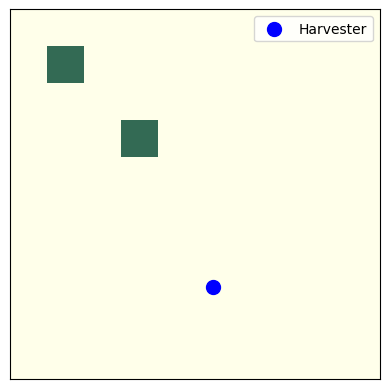

In [7]:

def animation_plot(env, ax):
    # Update plot for each frame
    ax.clear()
    grid = np.array(env.grid)  # Convert the grid to a NumPy array for visualization

    # Display the field
    ax.imshow(grid, cmap='YlGn_r', interpolation='none', alpha=0.8)

    # Plot the position of the harvester
    ax.scatter(env.position_harvester[1], env.position_harvester[0], color='blue', label='Harvester', s=100)

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    ax.legend()

def update(frame):
    global combine, env, ax
    action = combine.choose_action(env._get_observation())  # Choose action based on learned Q-table
    env.step(action)
    animation_plot(env, ax)

fig, ax = plt.subplots()

# Reset the environment for the animation
env.reset()

# Create the animation
animation = FuncAnimation(fig, update, frames=range(200), interval=100)

# Display the animation in Jupyter Notebook
HTML(animation.to_jshtml())
